# I. Introduction

## Background
The travel industry is highly influenced by seasonal trends and shifting consumer preferences. For a travel agency, staying ahead of these fluctuations is critical for optimizing marketing budgets and operational resources. To maintain a competitive edge, the company requires a data-driven approach to understand the historical demand for destinations like Pari Island and anticipate how its popularity will evolve in the future.

## Objective
The primary goal of this project is to forecast the popularity of tour packages to Pari Island for the next 12 months. By utilizing Time-Series Analysis algorithms—such as the ARIMA/SARIMAX model currently being developed—this project aims to provide accurate projections that will assist the company in strategic planning and decision-making for the upcoming year.

# II. Import Libraries

In [45]:
# Import Libraries
import pandas as pd                                                             # For data processing
import matplotlib.pyplot as plt                                                 # For visualization
from statsmodels.tsa.stattools import adfuller                                  # For stationarity check
from statsmodels.tsa.arima.model import ARIMA                                   # For modelling
import statsmodels.api as sm                                                    # For modelling
import pylab                                                                    # For visualization
from statsmodels.tsa.seasonal import seasonal_decompose                         # For decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf                   # For visualization ACF and PACF
from pmdarima import auto_arima                                                 # For hyperparameter tuning
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # For model evaluation
import dill                                                                     # For saving model

# III. Data Loading

In [46]:
# Load Data
data=pd.read_csv('dataset.csv', header=1)
data

,Week,Pulau Pari: (Indonesia)
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35
...,...,...
121,2024-07-21,43
122,2024-07-28,34
123,2024-08-04,32
124,2024-08-11,36


Code explanation

For extracting clean data with solid columns, it uses header function for dropping unsuitable data at the 0 index

In [47]:
# Check data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Week                     126 non-null    object
 1   Pulau Pari: (Indonesia)  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


Result Explanation

For ease of process, we change the column's names and data type

In [48]:
# Data manipulation
data = data.rename(columns={'Pulau Pari: (Indonesia)':'value','Week':'date'})
data['date'] = pd.to_datetime(data['date'])
data

,date,value
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35
...,...,...
121,2024-07-21,43
122,2024-07-28,34
123,2024-08-04,32
124,2024-08-11,36


In [49]:
# Check data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    126 non-null    datetime64[ns]
 1   value   126 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


In [50]:
# Set 'date' as the index of table
data = data.set_index('date')
data

,value
date,
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35
...,...
2024-07-21,43
2024-07-28,34
2024-08-04,32


In [51]:
# Define period time of data
data = data.asfreq('W') # Weekly

In [52]:
cleaned_data = data.to_csv('deployment/cleaned_data.csv')

# IV. Exploratory Data Analysis

In [53]:
# Split data train and test sets
len_train = round(len(data) * 0.9)
train = data[:len_train]
test = data[len_train:]
train

,value
date,
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35
...,...
2024-04-21,46
2024-04-28,37
2024-05-05,47


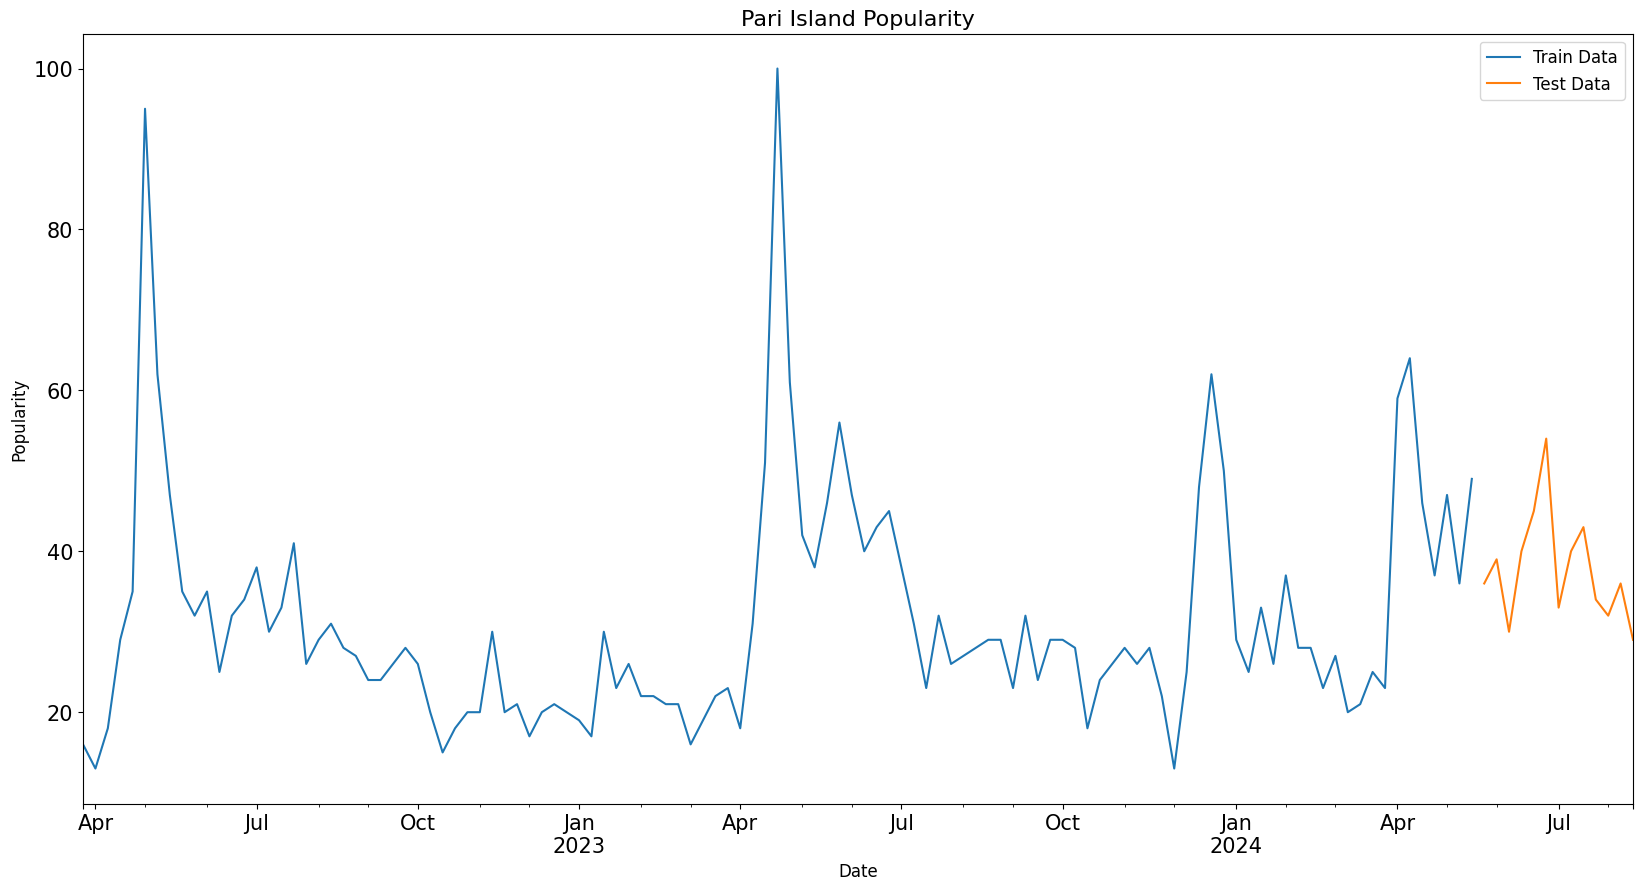

In [54]:
# Display time-series's line chart
train.value.plot(figsize=(20,10), title = 'Popularity', fontsize = 15, label='Train Data')
test.value.plot(figsize=(20,10), title = 'Popularity', fontsize = 15, label='Test Data')
plt.title('Pari Island Popularity', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.show()

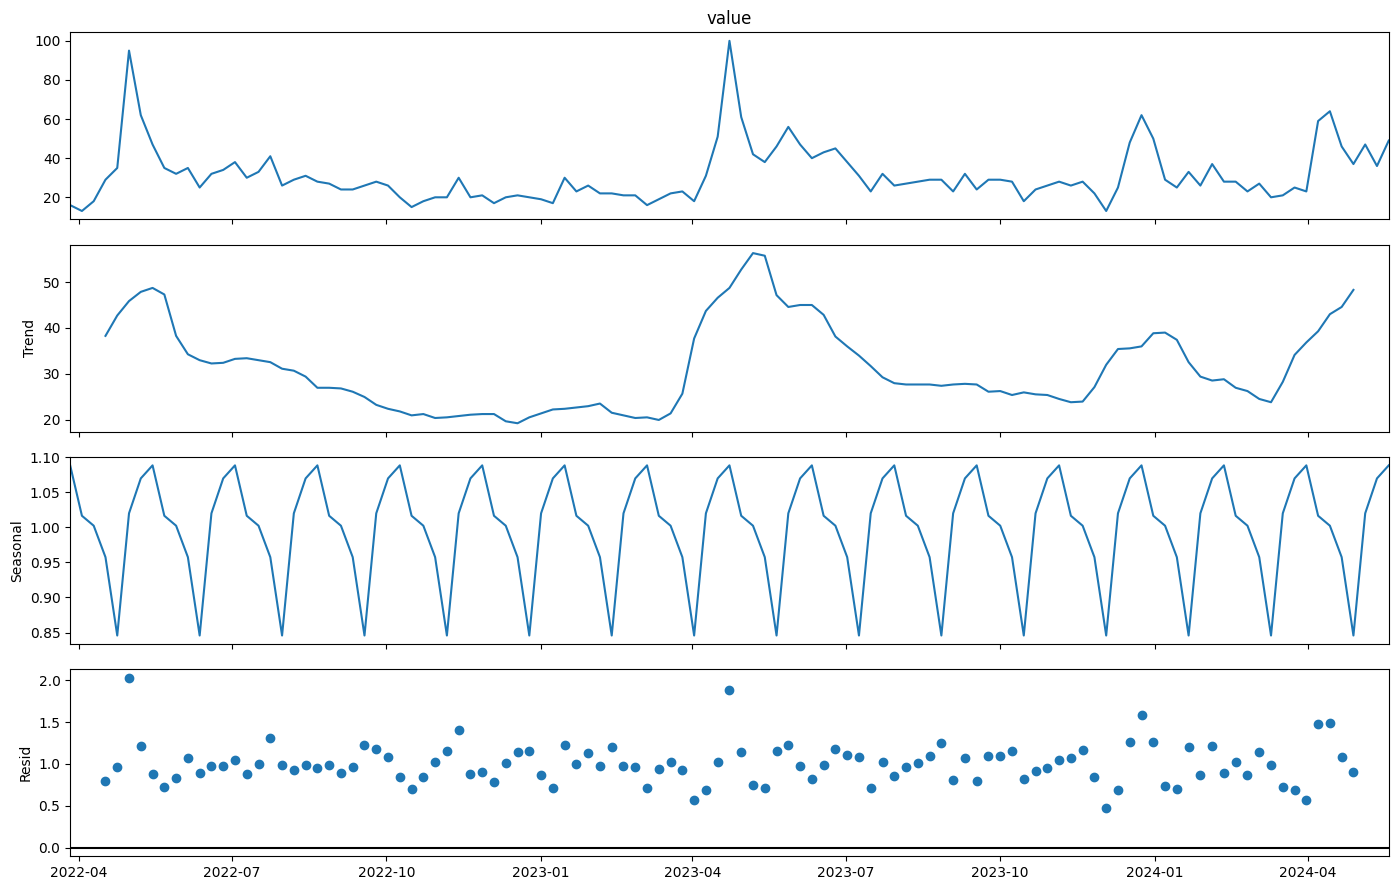

In [55]:
# Visualization for decomposing trend, seasonality and residual using additive model
pylab.rcParams['figure.figsize'] = (14, 9)
res_a = seasonal_decompose(train['value'], model='multiplicative', period=7)
ax=res_a.plot()
plt.show()

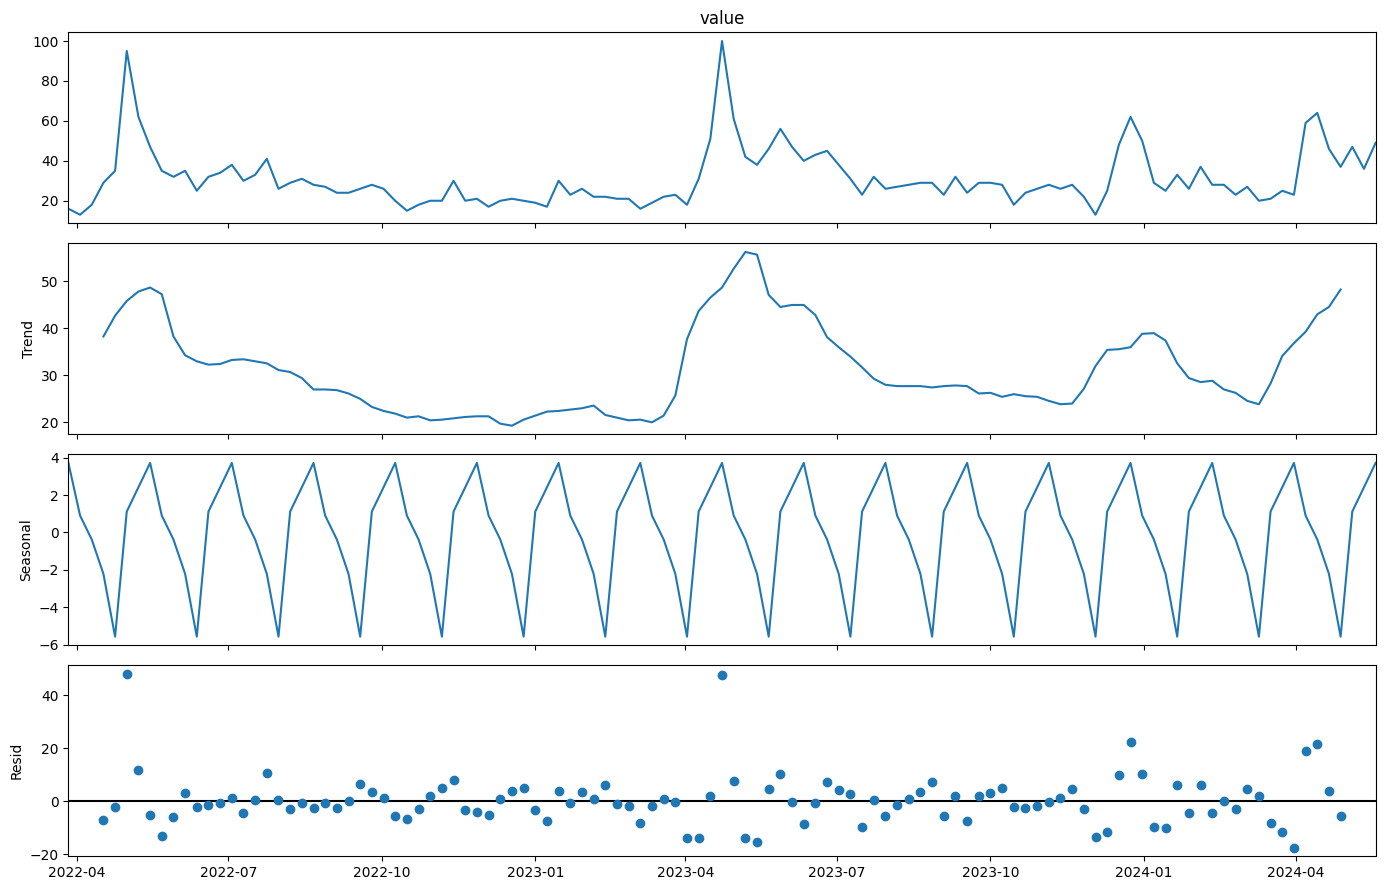

In [56]:
# Visualization for decomposing trend, seasonality and residual using additive model
pylab.rcParams['figure.figsize'] = (14, 9)
res_b = seasonal_decompose(train['value'], model='additive', period=7)
ax=res_b.plot()
plt.show()

Result Explanation

From both decompositions, eventhough additive has majority residual at around 0, however, there is a very high residual, almost 50. To catch this trend, we suggested to use multiplicative because it understands trend better and narrow range of residuals.

In [57]:
# Indetify seasonality with multiplicative model
max_season = res_a.seasonal.max()
res_a.seasonal[res_a.seasonal == max_season]

date
2022-03-27    1.088345
2022-05-15    1.088345
2022-07-03    1.088345
2022-08-21    1.088345
2022-10-09    1.088345
2022-11-27    1.088345
2023-01-15    1.088345
2023-03-05    1.088345
2023-04-23    1.088345
2023-06-11    1.088345
2023-07-30    1.088345
2023-09-17    1.088345
2023-11-05    1.088345
2023-12-24    1.088345
2024-02-11    1.088345
2024-03-31    1.088345
2024-05-19    1.088345
Name: seasonal, dtype: float64

Result Explanation

From the information above, we know that the seasonality is every 7 weeks.

In [58]:
# Check data stationarity for data train
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
check_stationarity(train['value'])

ADF Statistic: -3.642844
p-value: 0.004993
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581
Stationary


Result Explanation

The train set is stationary so that we don't need a differecing and the d is 0.

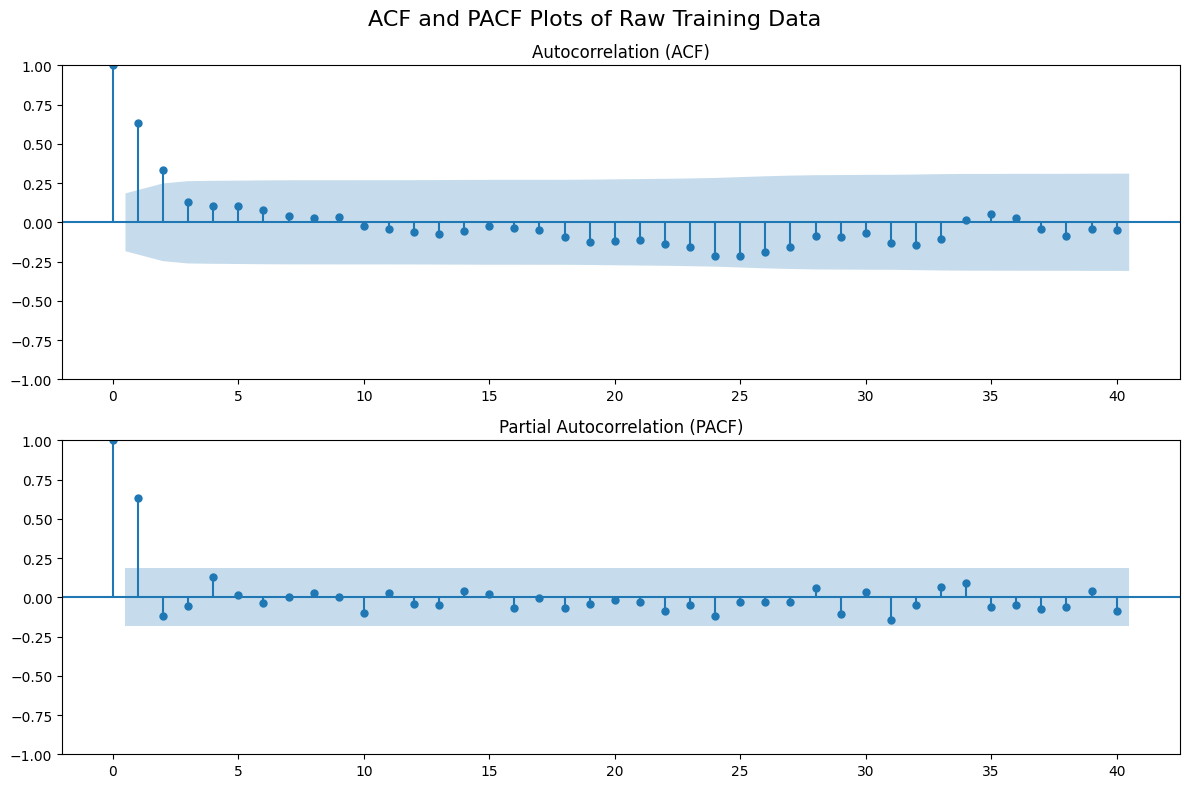

In [59]:
# Visualize ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('ACF and PACF Plots of Raw Training Data', fontsize=16)
plot_acf(train['value'], ax=ax1, lags=40)
ax1.set_title('Autocorrelation (ACF)')
plot_pacf(train['value'], ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

Result Explanation

- ACF, from the graphic, we can see that Lag 2 is the last lag before other lags on the blue area. Therefore, the q is 2
- PACF, from the graphic, we can see that Lag 1 is the last lag before other lags on the blue area. Therefore, the p is 1

# V. Model Definition and Training

## A. ARIMA

In [60]:
# Define hyperparameter with Auto ARIMA
stepwise_arima=auto_arima(train,
                          start_p=0, max_p=1, # Set p range based on PACF
                          start_q=0, max_q=2, # Set p range based on ACF
                          d=0,                # Set based on no need for differencing
                          seasonal=False)
print(stepwise_arima.summary())

c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -431.382
Date:                Sat, 07 Feb 2026   AIC                            868.765
Time:                        13:54:57   BIC                            876.947
Sample:                    03-27-2022   HQIC                           872.085
                         - 05-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.1812      3.083      3.627      0.000       5.139      17.224
ar.L1          0.6436      0.073      8.874      0.000       0.501       0.786
sigma2       120.5978      9.391     12.841      0.0

c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Result Explanation

From this tuning, we can see that (1,0,0) is the best hyperparameter package which will be implemented on ARIMA model

In [61]:
# Define ARIMA model with the best hyperparameters
model = ARIMA(train, order = (1,0,0))

# Train model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  113
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -431.382
Date:                Sat, 07 Feb 2026   AIC                            868.765
Time:                        13:54:57   BIC                            876.947
Sample:                    03-27-2022   HQIC                           872.085
                         - 05-19-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.3728      4.620      6.791      0.000      22.319      40.427
ar.L1          0.6436      0.073      8.873      0.000       0.501       0.786
sigma2       120.6071      9.393     12.840      0.000     102.197     139.017
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):               939.23
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             3.03
Prob(H) (two-sided):                  0.34   Kurtosis:                        15.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
# Fit for train set
train_predictions = result.predict(start=train.index[0], end=train.index[-1])
pred_train = pd.DataFrame(train_predictions, index=train.index)
train_concat = pd.concat([train, pred_train], axis=1)
train_concat

,value,predicted_mean
date,,
2022-03-27,16,31.372782
2022-04-03,13,21.479136
2022-04-10,18,19.548390
2022-04-17,29,22.766300
2022-04-24,35,29.845702
...,...,...
2024-04-21,46,52.371074
2024-04-28,37,40.786597
2024-05-05,47,34.994359


In [63]:
# Fit for test set
test_predictions = result.forecast(steps=len(test))
pred_test = pd.DataFrame(test_predictions)
pred_test.index=test.index
test_concat = pd.concat([test, pred_test], axis=1)
test_concat

,value,predicted_mean
date,,
2024-05-26,36,42.717343
2024-06-02,39,38.673938
2024-06-09,30,36.071675
2024-06-16,40,34.396905
2024-06-23,45,33.319054
2024-06-30,54,32.625368
2024-07-07,33,32.178924
2024-07-14,40,31.891601
2024-07-21,43,31.706684


## B. SARIMA

In [64]:
# Define hyperparameter with Auto ARIMA
stepwise_sarima=auto_arima(train,
                          start_p=0, max_p=1, 
                          start_q=0, max_q=2, 
                          d=0,                
                          seasonal=True,
                          m=7,               # The seasonality is every 7 weeks, and our data frequency is weekly, so the repetition is every 7 data. 
                          trace=True,
                          suppress_warnings=True)
print(stepwise_sarima.summary())

Performing stepwise search to minimize aic


c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=926.191, Time=0.00 sec


c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=870.749, Time=0.76 sec


c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=884.455, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1122.626, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=868.765, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=870.748, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=872.747, Time=0.09 sec


c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 

 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=869.393, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=882.833, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=886.904, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
Total fit time: 2.786 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -431.382
Date:                Sat, 07 Feb 2026   AIC                            868.765
Time:                        13:54:59   BIC                            876.947
Sample:                    03-27-2022   HQIC                           872.085
                         - 05-19-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\h8_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Result Explanation

From this tuning, we can see that (1,0,0)(0,0,0,0) is the best hyperparameter package which will be implemented on SARIMA model

In [65]:
# Define SARIMA model with the best hyperparameters
model2 = sm.tsa.statespace.SARIMAX(train,
                                  order=(1, 0, 0),
                                  seasonal_order=(0, 0, 0, 7))

# Train model
result2 = model2.fit(disp=False)
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  113
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -441.452
Date:                Sat, 07 Feb 2026   AIC                            886.904
Time:                        13:54:59   BIC                            892.359
Sample:                    03-27-2022   HQIC                           889.117
                         - 05-19-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9391      0.024     38.371      0.000       0.891       0.987
sigma2       142.0991      8.738     16.263      0.000     124.974     159.225
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               380.11
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             1.72
Prob(H) (two-sided):                  0.38   Kurtosis:                        11.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
# Fit for train set
train_predictions2 = result2.predict(start=train.index[0], end=train.index[-1])
pred_train2 = pd.DataFrame(train_predictions2, index=train.index)
train_concat2 = pd.concat([train, pred_train2], axis=1)
train_concat2

,value,predicted_mean
date,,
2022-03-27,16,0.000000
2022-04-03,13,15.025803
2022-04-10,18,12.208465
2022-04-17,29,16.904028
2022-04-24,35,27.234268
...,...,...
2024-04-21,46,60.103211
2024-04-28,37,43.199183
2024-05-05,47,34.747169


In [67]:
# Fit for test set
test_predictions2 = result2.forecast(steps=len(test))
pred_test2 = pd.DataFrame(test_predictions2)
pred_test2.index=test.index
test_concat2 = pd.concat([test, pred_test2], axis=1)
test_concat2

,value,predicted_mean
date,,
2024-05-26,36,46.016521
2024-06-02,39,43.214698
2024-06-09,30,40.583471
2024-06-16,40,38.112452
2024-06-23,45,35.791887
2024-06-30,54,33.612615
2024-07-07,33,31.566033
2024-07-14,40,29.644061
2024-07-21,43,27.839114


# VI. Model Evaluation

## A. ARIMA

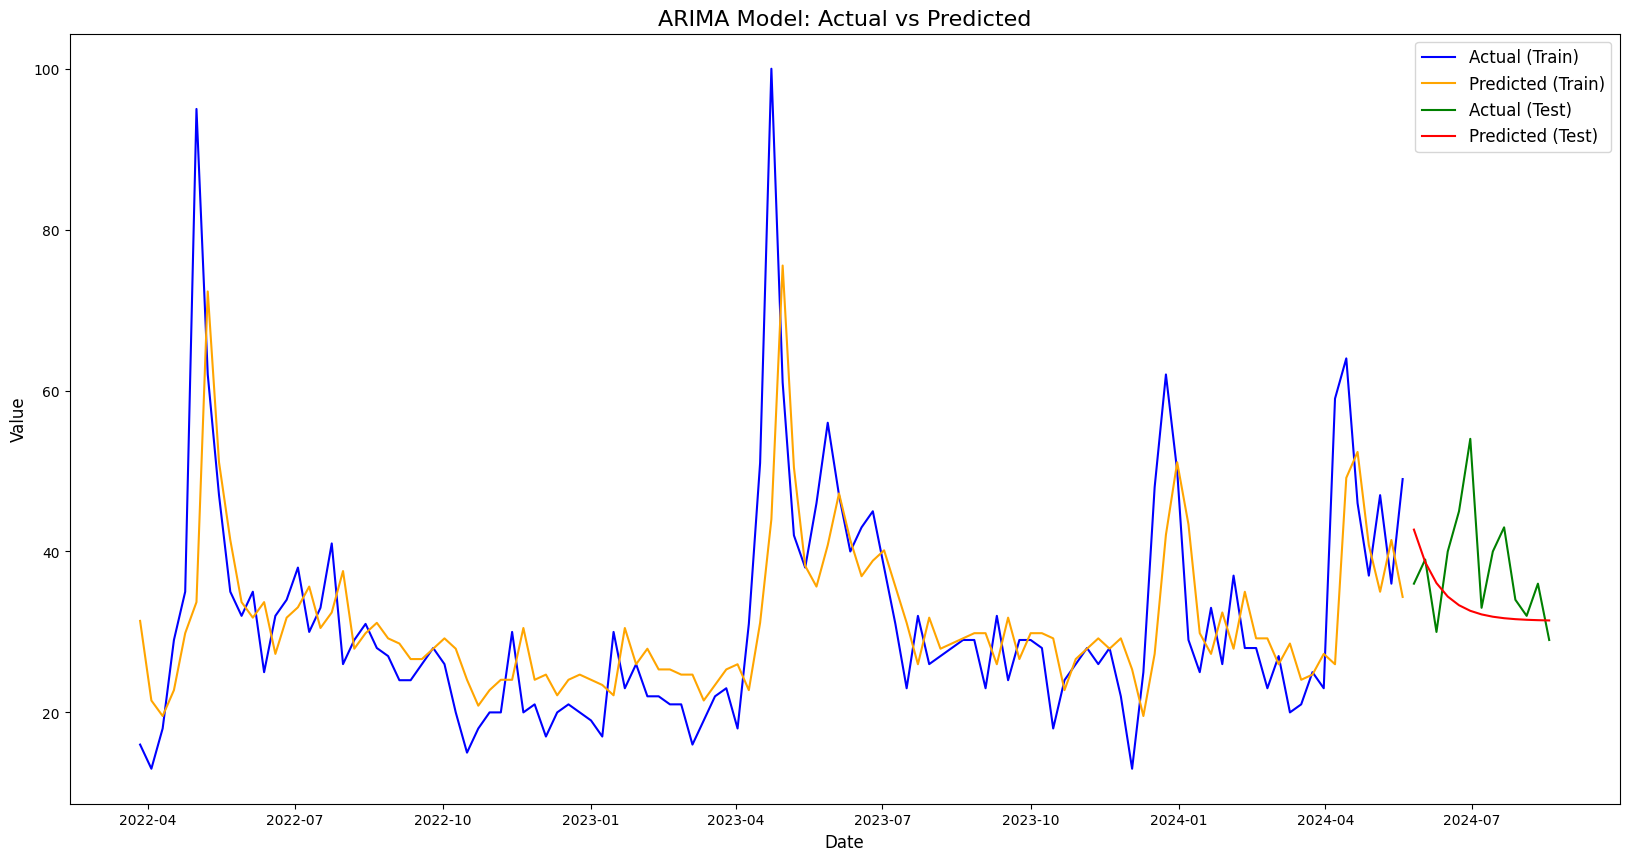

In [68]:
# Visualize ARIMA Model Result
plt.figure(figsize=(20, 10))

# Plot Data Train (Kolom 'value' dan 'predicted_mean')
plt.plot(train_concat['value'], label='Actual (Train)', color='blue')
plt.plot(train_concat['predicted_mean'], label='Predicted (Train)', color='orange')

# Plot Data Test (Kolom 'value' dan 'predicted_mean')
plt.plot(test_concat['value'], label='Actual (Test)', color='green')
plt.plot(test_concat['predicted_mean'], label='Predicted (Test)', color='red')

# Menambahkan judul dan label sumbu
plt.title('ARIMA Model: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Menampilkan Legend
plt.legend(loc='upper right', fontsize=12)

plt.show()

In [69]:
# Model ARIMA
mae_train = mean_absolute_error(train, train_predictions)
mae_test = mean_absolute_error(test, test_predictions)
mape_train = mean_absolute_percentage_error(train, train_predictions)
mape_test = mean_absolute_percentage_error(test, test_predictions)
print('Model ARIMA')
print(f"Train MAE: {mae_train:.4f}")
print(f"Test MAE:  {mae_test:.4f}")
print(f"Train MAPE: {mape_train:.4f}")
print(f"Test MAPE:  {mape_test:.4f}")

Model ARIMA
Train MAE: 6.8065
Test MAE:  6.2974
Train MAPE: 0.2152
Test MAPE:  0.1522


Result Explanation

From MAE value, between train and test is fit because the gap is close. However, for MAPE value, the gap is quite far (overfitting)

## B. SARIMA

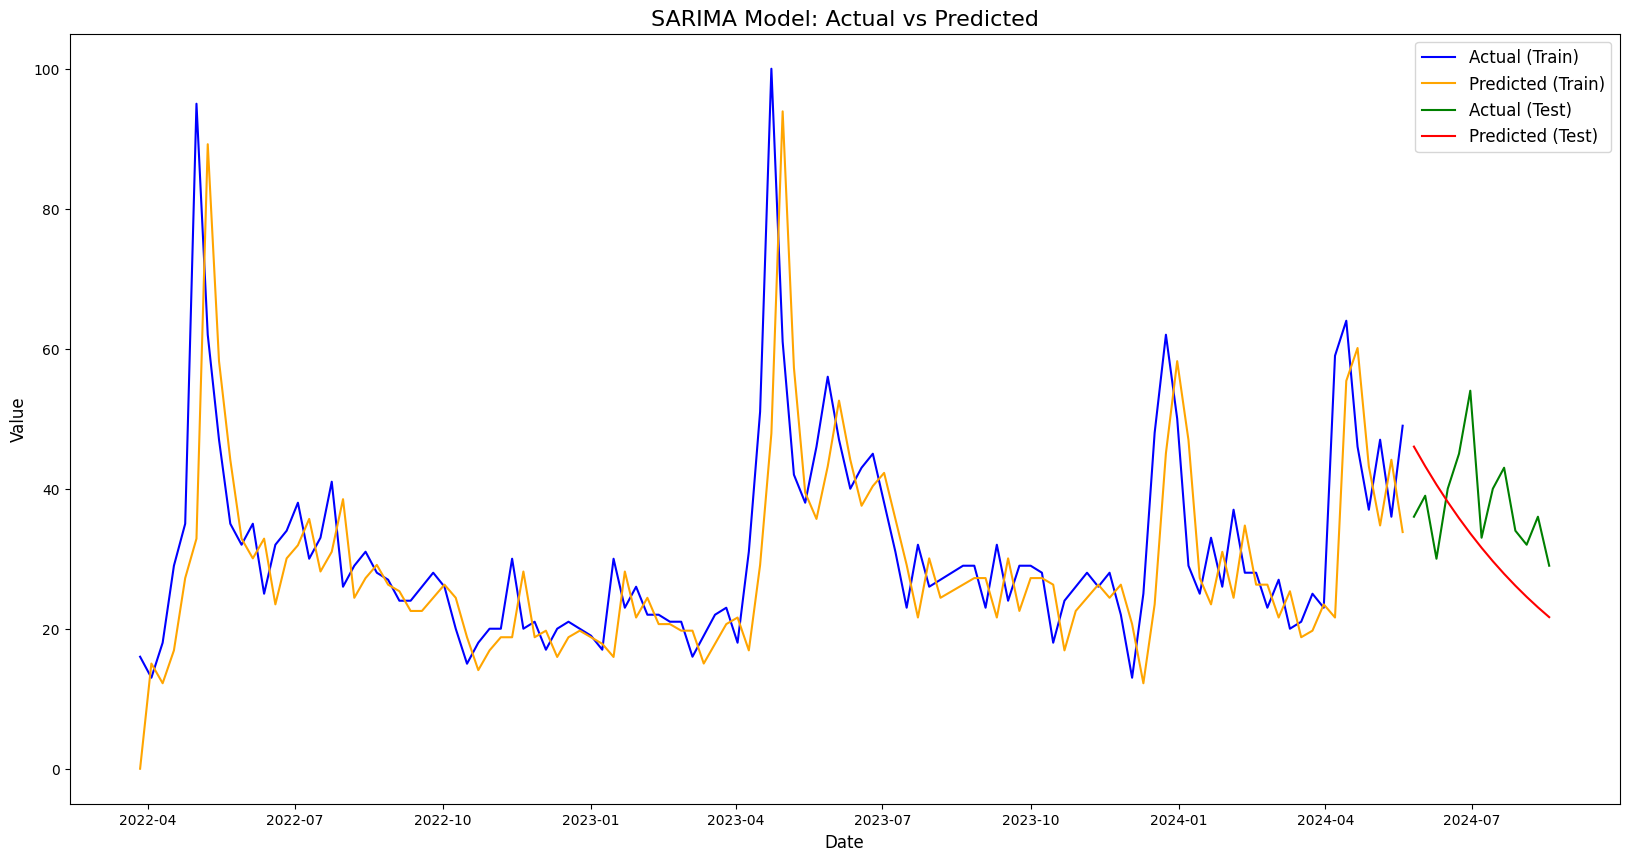

In [70]:
# Visualize ARIMA Model Result
plt.figure(figsize=(20, 10))

# Plot Data Train (Kolom 'value' dan 'predicted_mean')
plt.plot(train_concat2['value'], label='Actual (Train)', color='blue')
plt.plot(train_concat2['predicted_mean'], label='Predicted (Train)', color='orange')

# Plot Data Test (Kolom 'value' dan 'predicted_mean')
plt.plot(test_concat2['value'], label='Actual (Test)', color='green')
plt.plot(test_concat2['predicted_mean'], label='Predicted (Test)', color='red')

# Menambahkan judul dan label sumbu
plt.title('SARIMA Model: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Menampilkan Legend
plt.legend(loc='upper right', fontsize=12)

plt.show()

In [71]:
# Model SARIMA
mae_train = mean_absolute_error(train, train_predictions2)
mae_test = mean_absolute_error(test, test_predictions2)
mape_train = mean_absolute_percentage_error(train, train_predictions2)
mape_test = mean_absolute_percentage_error(test, test_predictions2)
print('Model SARIMA')
print(f"Train MAE: {mae_train:.4f}")
print(f"Test MAE:  {mae_test:.4f}")
print(f"Train MAPE: {mape_train:.4f}")
print(f"Test MAPE:  {mape_test:.4f}")

Model SARIMA
Train MAE: 7.6458
Test MAE:  9.1417
Train MAPE: 0.2195
Test MAPE:  0.2385


Result Explanation

From MAE value, between train and test is fit because the gap is far (underfitting). However, for MAPE value, the gap is quite far (underfitting)

The Best Model

Considering both models, ARIMA gives lower MAE and MAPE, although the MAPE gap between train and test is quite far. However, ARIMA is still the best than SARIMA because SARIMA's MAE and MAPE have higher values and far gap between train and test.

# VII. Model Inference

In [72]:
# Saving Model                                              
with open('deployment/final_model.pkl', 'wb') as a:
    dill.dump(result, a)

In [73]:
# Load Model
with open('deployment/final_model.pkl', 'rb') as a:
    final_model = dill.load(a)

In [74]:
# Determine period
period=52

# Predict
forecast = final_model.forecast(steps=period)

In [75]:
# Data check
forecast.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 52 entries, 2024-05-26 to 2025-05-18
Freq: W-SUN
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
52 non-null     float64
dtypes: float64(1)
memory usage: 832.0 bytes


In [76]:
# Define date for forecasted values
last_date = data.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                             periods=period, freq='W')
# Set index
forecast.index = future_dates

In [77]:
# Concat for having dataframe which will be exported
df_forecast = pd.concat([data, forecast.rename('forecast')], axis=1)
df_forecast

,value,forecast
2022-03-27,16.0,NaN
2022-04-03,13.0,NaN
2022-04-10,18.0,NaN
2022-04-17,29.0,NaN
2022-04-24,35.0,NaN
...,...,...
2025-07-20,NaN,31.372782
2025-07-27,NaN,31.372782
2025-08-03,NaN,31.372782
2025-08-10,NaN,31.372782


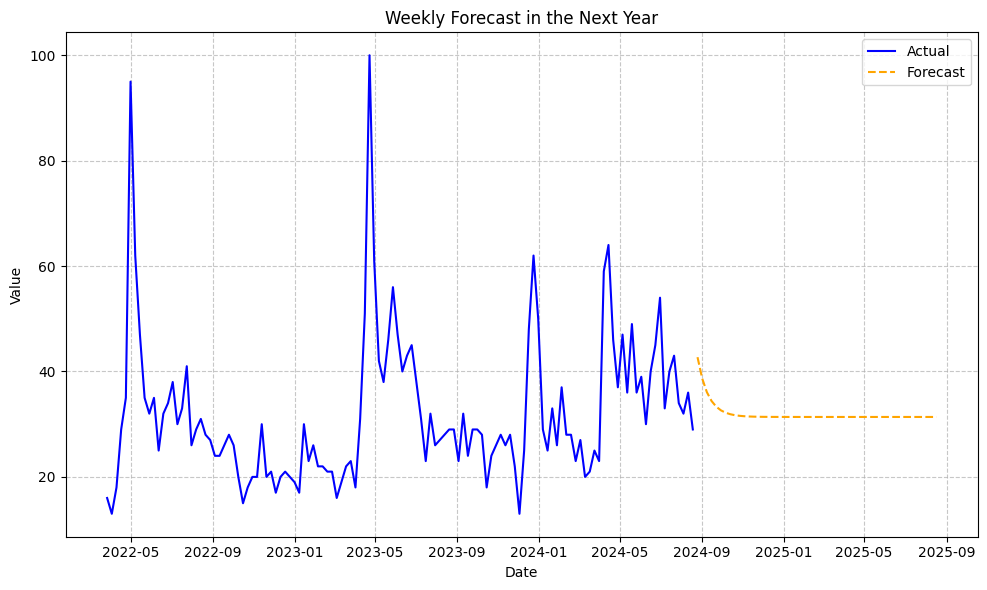

In [78]:
# Visualization
plt.figure(figsize=(10,6))
plt.plot(df_forecast.index, df_forecast['value'], label='Actual', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')

plt.title('Weekly Forecast in the Next Year')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()